# NFL 4th-Down Win Percentage Recommendation

- Author: Marco Villagran
- Seasons: 2016-2024

In [1]:
import os, json, math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.ticker import PercentFormatter, MultipleLocator

import statsmodels.api as sm


COL_W, TWO_COL_W = 3.5, 7.2
WIDTH = COL_W
HEIGHT = WIDTH * 1.9

mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})
colors = {"go":"#7570b3", "fg":"#d95f02", "punt":"#1b9e77"}

DATA = "../data/processed/4thdown_labeled.csv"
RAW_PBP = "../data/raw/pbp_2016_2024.parquet"

os.makedirs("reports/figures", exist_ok=True)

df = pd.read_csv(DATA)
df_raw = pd.read_parquet(RAW_PBP)
print("Number of 4th downs", len(df))
print("Number of columns:" , len(df.columns))
print("columns: ", df.dtypes)

Number of 4th downs 37335
Number of columns: 27
columns:  season                      int64
game_id                    object
play_id                     int64
quarter                     int64
game_seconds_remaining      int64
half_seconds_remaining      int64
yardline_100                int64
ydstogo                     int64
score_differential          int64
receive_2h_ko                bool
timeouts_off                int64
timeouts_def                int64
roof                       object
surface                    object
temp_f                    float64
wind_mph                  float64
spread_line               float64
wp                        float64
wp_go                     float64
wp_fg                     float64
wp_punt                   float64
dwp_go                    float64
dwp_fg                    float64
dwp_punt                  float64
p_fg_make                 float64
p_go_convert              float64
punt_net_yds              float64
dtype: object


## 01 Data Cleaning

### Data Normalization

In [2]:
# Normalize roof (open or closed)
df['roof'].value_counts(normalize=True)
df['roof'].replace({'dome':'closed', 'outdoors':'open'}, inplace=True)

# Normalize surface (grass or turf)
df['surface'] = np.where(df['surface'] == 'grass', 'grass', 'turf')

closed_mask = df['roof'].isin(['closed'])
open_mask   = ~closed_mask

### Missing values handling

In [3]:
# Cols with missing values
missing = df.isna().mean()
missing = missing[missing > 0].sort_values(ascending=False)
print("Columns with missing values (% missing):")
print((missing * 100).round(2))

Columns with missing values (% missing):
punt_net_yds    100.00
temp_f           34.34
wind_mph         34.34
wp_punt          26.04
dwp_punt         26.04
p_go_convert      0.00
dtype: float64


In [4]:
df = df.drop(columns=["punt_net_yds"])

# drop rows without target variables (WP diff)
targets = ["wp_go","wp_fg","wp_punt"]
df['wp_punt'].fillna(df['wp_punt'].min(), inplace=True)

# compute win_percentage differentials from win percentages    
df["dwp_go"]   = df["wp_go"]   - df["wp"]
df["dwp_fg"]   = df["wp_fg"]   - df["wp"]
df["dwp_punt"] = df["wp_punt"] - df["wp"]

before = len(df)
df = df.dropna(subset=targets)
print("Dropped rows with missing Win Percentages:", before - len(df))

Dropped rows with missing Win Percentages: 0


In [5]:
# Fill temp_f by roof type
avg_open_temp = df.loc[open_mask, 'temp_f'].mean()
df.loc[closed_mask, 'temp_f'] = df.loc[closed_mask, 'temp_f'].fillna(70.0)
df.loc[open_mask, 'temp_f'] = df.loc[open_mask, 'temp_f'].fillna(avg_open_temp)

# Do the same for wind_mph
avg_open_wind = df.loc[open_mask, 'wind_mph'].mean()
df.loc[closed_mask, 'wind_mph'] = df.loc[closed_mask, 'wind_mph'].fillna(0.0)
df.loc[open_mask, 'wind_mph'] = df.loc[open_mask, 'wind_mph'].fillna(avg_open_wind)

### Hygiene clips

In [6]:
# yards
df["yardline_100"] = df["yardline_100"].clip(0, 100)
df["ydstogo"] = df["ydstogo"].clip(lower=1)

# game time
df["quarter"] = df["quarter"].clip(1, 6).astype("Int64")
df["game_seconds_remaining"] = df["game_seconds_remaining"].clip(lower=0)
df["half_seconds_remaining"] = df["half_seconds_remaining"].clip(lower=0)

# game score
df["score_differential"] = df["score_differential"]
df["timeouts_off"] = df["timeouts_off"].clip(0, 3).fillna(0).astype(int)
df["timeouts_def"] = df["timeouts_def"].clip(0, 3).fillna(0).astype(int)

In [7]:
# Drop missing values (1)
before = len(df)
df = df.dropna()
print("Dropped rows with missings:", before - len(df))

Dropped rows with missings: 1


## 02 EDA

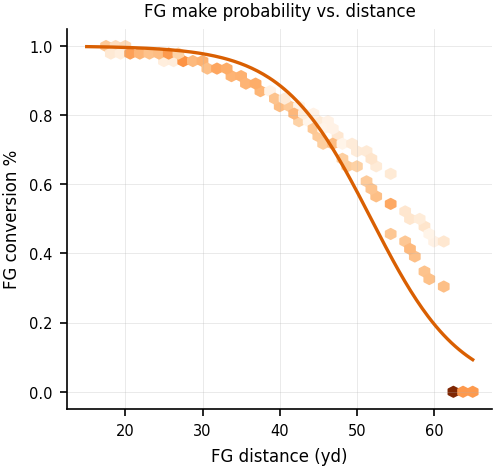

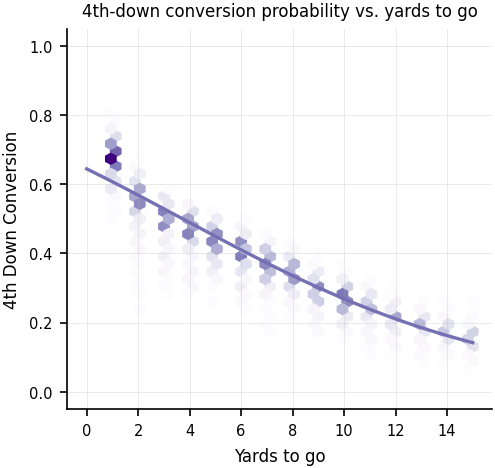

In [8]:
df["fg_dist_yd"] = df["yardline_100"] + 17

s = df.copy()

fig, ax_fg = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
ax_fg.hexbin(
    s["fg_dist_yd"], s["p_fg_make"],
    gridsize=40, cmap="Oranges",
    extent=(15, 65, 0, 1), mincnt=1
)

X_fg = sm.add_constant(s["fg_dist_yd"])
y_fg = s["p_fg_make"]
model_fg = sm.GLM(y_fg, X_fg, family=sm.families.Binomial()).fit()
x_pred_fg = np.linspace(15, 65, 200)
y_pred_fg = model_fg.predict(sm.add_constant(x_pred_fg))

ax_fg.plot(x_pred_fg, y_pred_fg, color=colors["fg"], lw=1.6)
corr_fg = np.corrcoef(s["fg_dist_yd"], s["p_fg_make"])[0, 1]

ax_fg.set_title("FG make probability vs. distance", fontsize=8)
ax_fg.set_xlabel("FG distance (yd)")
ax_fg.set_ylabel("FG conversion %")


fig.tight_layout()
fig.savefig("../reports/figures/fg_prob_vs_distance.png")
plt.show()

#  4th-down conversion probability vs. yards to go 
s = df.copy()

fig, ax_go = plt.subplots(figsize=(WIDTH, WIDTH*0.95))

ax_go.hexbin(
    s["ydstogo"], s["p_go_convert"],
    gridsize=40, cmap="Purples",
    extent=(0, 15, 0, 1), mincnt=1
)

X_go = sm.add_constant(s["ydstogo"])
y_go = s["p_go_convert"]
model_go = sm.GLM(y_go, X_go, family=sm.families.Binomial()).fit()
x_pred_go = np.linspace(0, 15, 200)
y_pred_go = model_go.predict(sm.add_constant(x_pred_go))

ax_go.plot(x_pred_go, y_pred_go, color=colors['go'], lw=1.6)
corr_go = np.corrcoef(s["ydstogo"], s["p_go_convert"])[0, 1]

ax_go.set_title("4th-down conversion probability vs. yards to go", fontsize=8)
ax_go.set_xlabel("Yards to go")
ax_go.set_ylabel("4th Down Conversion")


fig.tight_layout()
fig.savefig("../reports/figures/go_prob_vs_ytg.png")
plt.show()

Similar WP diff rate (WP differential gap < 0.5%): 0.288
go      0.423
punt    0.381
fg      0.195
Name: share, dtype: float64
teacher_best    fg    go  punt
yl_bin                        
0-20          54.3  45.7   NaN
21-40         51.5  44.3   4.2
41-60          1.7  54.9  43.3
61-80          0.0  35.1  64.9
81-100         0.0  21.9  78.0

teacher_best    fg    go  punt
ytg_bin                       
1              7.3  89.5   3.2
2             16.1  68.9  14.9
3-6           20.8  50.8  28.4
7-10          25.6  25.9  48.5
>10           22.7   7.5  69.8
Similar WP diff rate in late/close: 0.096


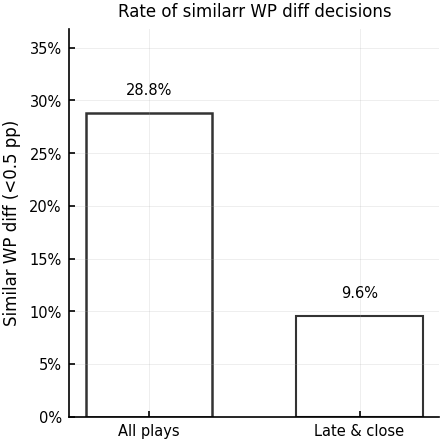

In [ ]:
# Best action
dwp_mat = df[["dwp_go","dwp_fg","dwp_punt"]].to_numpy()
vals = np.where(np.isnan(dwp_mat), -np.inf, dwp_mat)
best_idx = vals.argmax(axis=1)
idx_to_name = {0:"go", 1:"fg", 2:"punt"}
df["teacher_best"] = pd.Series(best_idx, index=df.index).map(idx_to_name)

# Best margin (best - second best)
top2 = np.sort(vals, axis=1)[:, -2:]
df["best_margin"] = top2[:,1] - top2[:,0]

print("Similar WP diff rate (WP differential gap < 0.5%):", (df["best_margin"] < 0.005).mean().round(3))
print(df["teacher_best"].value_counts(normalize=True).rename("share").round(3))

#  Best action frequency with 95% CI 
labels = ["go","fg","punt"]
n = len(df)
counts = df["teacher_best"].value_counts().reindex(labels, fill_value=0).to_numpy()
props  = counts / n

def cut(x, bins, labels):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True)

df["yl_bin"]  = cut(df.yardline_100, [0,20,40,60,80,100], ["0-20","21-40","41-60","61-80","81-100"])
df["ytg_bin"] = cut(df.ydstogo, [1,2,3,6,10,50], ["1","2","3-6","7-10",">10"])

yl_share = (df.groupby("yl_bin")["teacher_best"]
              .value_counts(normalize=True)
              .rename("share").mul(100).round(1).unstack())
ytg_share = (df.groupby("ytg_bin")["teacher_best"]
              .value_counts(normalize=True)
              .rename("share").mul(100).round(1).unstack())
print(yl_share); print(); print(ytg_share)

late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
print("Similar WP diff rate in late/close:", (late_close["best_margin"] < 0.005).mean().round(3))

labels = ["go","fg","punt"]
n = len(df)
counts = df["teacher_best"].value_counts().reindex(labels, fill_value=0).to_numpy()
props  = counts / n

th = 0.005
m_all = df["best_margin"].to_numpy()
m_all = m_all[np.isfinite(m_all)]
late_close = df[(df.game_seconds_remaining < 600) & (df["score_differential"].abs() <= 8)]
m_lc = late_close["best_margin"].to_numpy()
m_lc = m_lc[np.isfinite(m_lc)]

rate_all = (m_all < th).mean()
rate_lc  = (m_lc  < th).mean()

# Plot
fig, ax = plt.subplots(figsize=(WIDTH*0.9, WIDTH*0.9))

x = [0, 1]
rates = [rate_all, rate_lc]

# All plays
ax.bar(x[0], rates[0], width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.2, label="All plays")
# Late & close game
ax.bar(x[1], rates[1], width=0.6, facecolor="white", edgecolor="0.2", linewidth=1.0, label="Late & close")

for xi, val in zip(x, rates):
    ax.text(xi, val + 0.015, f"{val*100:.1f}%", ha="center", va="bottom", fontsize=7)

ax.set_xticks(x)
ax.set_xticklabels(["All plays", "Late & close"])
ax.set_ylim(0, max(rates) + 0.08)
ax.grid(alpha=0.25)
ax.set_ylabel("Similar WP diff (<0.5 pp)", fontsize=8)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y*100:.0f}%"))
ax.tick_params(direction="in", which="both", length=3, width=0.8)
ax.set_title("Rate of similarr WP diff decisions", fontsize=8)

fig.tight_layout()
fig.savefig("../reports/figures/similar_wp_diff_barchart.png")
plt.show()


In [ ]:
for col in ["roof","surface"]:
    tbl = (df.groupby(col)["teacher_best"].value_counts(normalize=True)
             .rename("share").mul(100).round(1).unstack())
    print("\n- ", col.upper()); print(tbl)

### Best decisions by field positions and yards-to-go

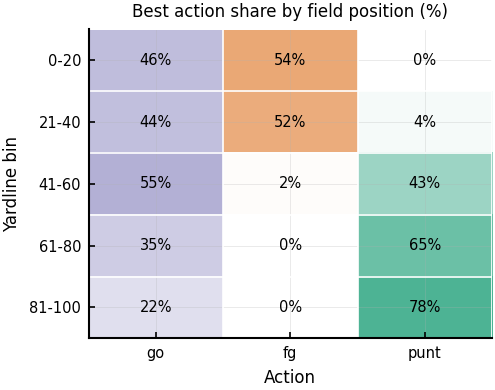

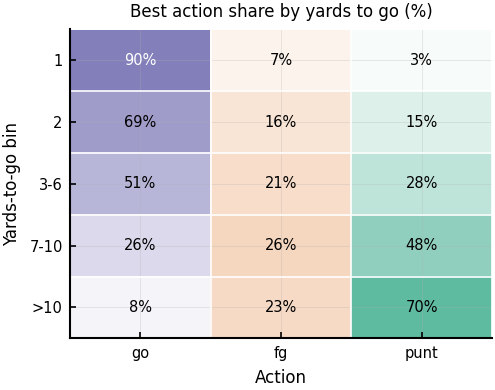

In [10]:
# field position best descision heatmap
labels = ["go","fg","punt"]
yl = yl_share[labels].fillna(0.0)
rows, cols = yl.shape
norm = (yl.to_numpy() / 100.0)

base_rgb = np.array([mcolors.to_rgb(colors[k]) for k in labels])
img = np.ones((rows, cols, 3))
for j in range(cols):
    img[:, j, :] = 1.0 - (1.0 - base_rgb[j]) * norm[:, [j]]

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.8))
ax.imshow(img, aspect="auto", interpolation="nearest")

for r in range(rows+1):
    ax.axhline(r-0.5, color="white", lw=0.8)
for c in range(cols+1):
    ax.axvline(c-0.5, color="white", lw=0.8)

ax.set_xticks(np.arange(cols))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(rows))
ax.set_yticklabels(yl.index)
ax.tick_params(direction="in", length=3, width=0.8)

for i in range(rows):
    for j in range(cols):
        v = yl.iloc[i, j]
        rgb = img[i, j, :]
        lum = 0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2]
        ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                fontsize=7, color=("black" if lum > 0.55 else "white"))

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.set_title("Best action share by field position (%)", fontsize=8)
ax.set_xlabel("Action")
ax.set_ylabel("Yardline bin")

fig.tight_layout()
fig.savefig("../reports/figures/best_action_by_yl_trihue_polished.png")
plt.show()

# yards to go best descision heatmap
import numpy as np, matplotlib.colors as mcolors, matplotlib.pyplot as plt

labels = ["go","fg","punt"]
yt = ytg_share[labels].fillna(0.0)  # % values
rows, cols = yt.shape
norm = (yt.to_numpy() / 100.0)

base_rgb = np.array([mcolors.to_rgb(colors[k]) for k in labels])
img = np.ones((rows, cols, 3))
for j in range(cols):
    img[:, j, :] = 1.0 - (1.0 - base_rgb[j]) * norm[:, [j]]

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.8))
ax.imshow(img, aspect="auto", interpolation="nearest")

for r in range(rows+1):
    ax.axhline(r-0.5, color="white", lw=0.8)
for c in range(cols+1):
    ax.axvline(c-0.5, color="white", lw=0.8)

ax.set_xticks(np.arange(cols))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(rows))
ax.set_yticklabels(yt.index)
ax.tick_params(direction="in", length=3, width=0.8)

for i in range(rows):
    for j in range(cols):
        v = yt.iloc[i, j]
        rgb = img[i, j, :]
        lum = 0.2126*rgb[0] + 0.7152*rgb[1] + 0.0722*rgb[2]
        ax.text(j, i, f"{v:.0f}%", ha="center", va="center",
                fontsize=7, color=("black" if lum > 0.55 else "white"))

ax.spines["left"].set_visible(True)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_color("black")
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_linewidth(1.0)
ax.spines["bottom"].set_linewidth(1.0)

ax.set_title("Best action share by yards to go (%)", fontsize=8)
ax.set_xlabel("Action")
ax.set_ylabel("Yards-to-go bin")

fig.tight_layout()
fig.savefig("../reports/figures/best_action_by_ytg_trihue_polished.png")
plt.show()


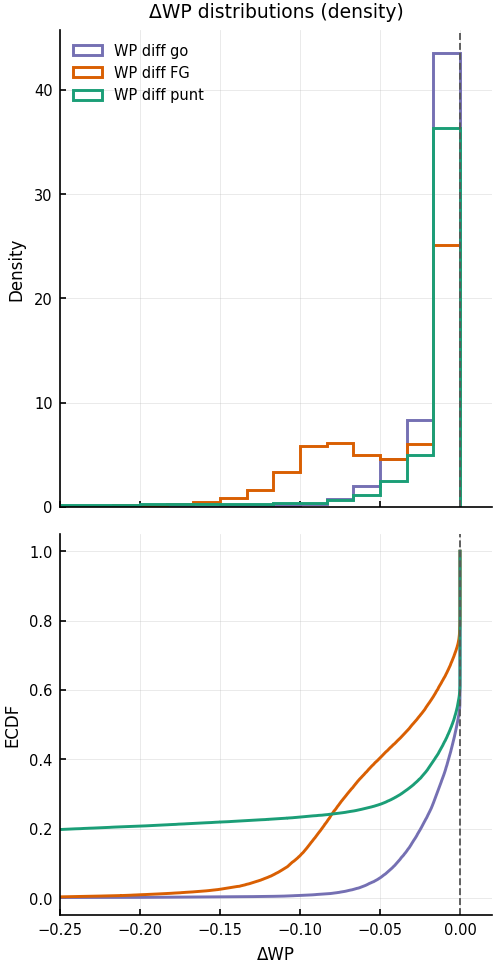

In [12]:
series = [
    np.asarray(df["dwp_go"],   float),
    np.asarray(df["dwp_fg"],   float),
    np.asarray(df["dwp_punt"], float),
]
labels = ["WP diff go", "WP diff FG", "WP diff punt"]
keys   = ["go", "fg", "punt"]  # match colors dict keys
series = [s[np.isfinite(s)] for s in series]

# shared bins
lo = min(s.min() for s in series)
hi = max(s.max() for s in series)
edges = np.linspace(lo, hi, 60 + 1)

fig, (ax_pdf, ax_ecdf) = plt.subplots(
    2, 1, figsize=(WIDTH, HEIGHT), sharex=True,
    gridspec_kw={"height_ratios": [2.0, 1.6]}
)

# density
for s, lab, key in zip(series, labels, keys):
    ax_pdf.hist(s, bins=edges, histtype="step", density=True,
                label=lab, linewidth=1.4, color=colors[key])
ax_pdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_pdf.set_title("ΔWP distributions (density)")
ax_pdf.set_ylabel("Density")
ax_pdf.legend(loc="upper left", frameon=False)
ax_pdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_pdf.set_xlim(-0.25, 0.02)  # zoom

# ECDF
for s, lab, key in zip(series, labels, keys):
    x = np.sort(s); F = np.arange(1, x.size + 1) / x.size
    ax_ecdf.plot(x, F, label=lab, linewidth=1.4, color=colors[key])
ax_ecdf.axvline(0.0, color="0.35", linestyle="--", linewidth=0.9)
ax_ecdf.set_xlabel("ΔWP")
ax_ecdf.set_ylabel("ECDF")
ax_ecdf.tick_params(direction="in", which="both", length=3, width=0.8)
ax_ecdf.set_xlim(-0.25, 0.02)

fig.tight_layout()
fig.savefig("../reports/figures/eda_dwp_dists_col.png")
plt.show()


In [13]:
a

NameError: name 'a' is not defined

In [ ]:
pbp = pd.read_parquet(RAW_PBP)  # raw play-by-play
coach = pbp.loc[pbp["down"].eq(4), ["game_id","play_id","play_type"]].copy()

# Map play_type -> choice
GO_TYPES = {"run","pass","qb_kneel","qb_spike","timeout","no_play"}  # runs/passes count as "go"
def map_choice(pt):
    if pd.isna(pt): return np.nan
    pt = str(pt).lower()
    if pt == "field_goal": return "fg"
    if pt == "punt": return "punt"
    if pt in GO_TYPES: return "go"
    # Unknowns (e.g., 'fake_punt', onside kicks shouldn’t appear)
    return np.nan

coach["coach_choice"] = coach["play_type"].map(map_choice)
coach = coach.dropna(subset=["coach_choice"])

eda = df.merge(coach[["game_id","play_id","coach_choice"]], on=["game_id","play_id"], how="left")
eda["disagree"] = eda["coach_choice"].ne(eda["teacher_best"])

# Regret (teacher best ΔWP - chosen ΔWP)
def chosen_dwp(row):
    if row["coach_choice"] == "go":   return row["dwp_go"]
    if row["coach_choice"] == "fg":   return row["dwp_fg"]
    if row["coach_choice"] == "punt": return row["dwp_punt"]
    return np.nan

eda["chosen_dwp"] = eda.apply(chosen_dwp, axis=1)
eda["best_dwp"]   = eda[["dwp_go","dwp_fg","dwp_punt"]].max(axis=1)
eda["regret"]     = eda["best_dwp"] - eda["chosen_dwp"]

overall_disagree = eda["disagree"].mean()
avg_regret = eda["regret"].dropna().mean()
print('overall dissagree: ', overall_disagree)
print('average regret: ', avg_regret)

overall dissagree:  0.3090397750100442
average regret:  0.004164338683897989


In [ ]:
# Where do coaches disagree more?
regret_by_yl = eda.groupby("yl_bin")["regret"].mean().round(4)
regret_by_ytg = eda.groupby("ytg_bin")["regret"].mean().round(4)
regret_by_yl, regret_by_ytg


(yl_bin
 0-20      0.0040
 21-40     0.0042
 41-60     0.0051
 61-80     0.0037
 81-100    0.0031
 Name: regret, dtype: float64,
 ytg_bin
 1       0.0083
 2       0.0067
 3-6     0.0047
 7-10    0.0023
 >10     0.0017
 Name: regret, dtype: float64)

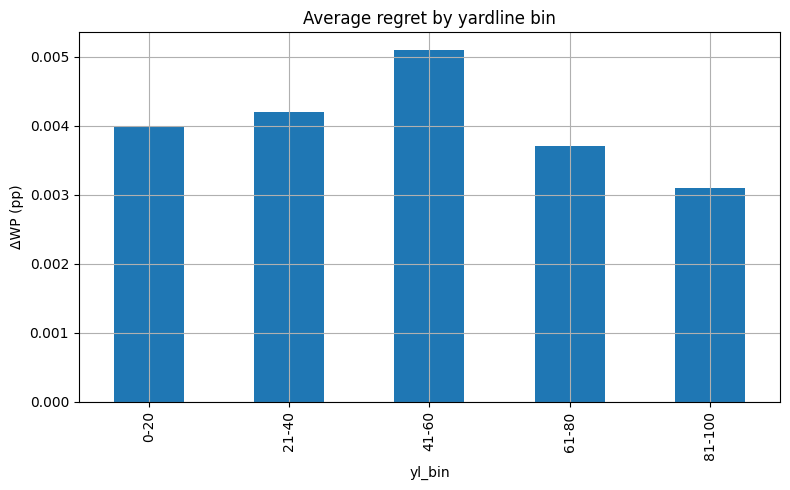

In [ ]:
# Plot regret by yardline bin
fig, ax = plt.subplots()
regret_by_yl.plot(kind="bar", ax=ax)
ax.set_title("Average regret by yardline bin")
ax.set_ylabel("ΔWP (pp)")
plt.tight_layout(); plt.savefig("reports/figures/eda_regret_by_yardline.png"); plt.show()


In [ ]:
# Ensure no clearly post-outcome columns slipped in
suspicious = [c for c in df.columns if any(k in c.lower() for k in ["td","intercept","yards_gained","epa","success"])]
suspicious

[]

In [ ]:
# Season coverage & potential drift
df.groupby("season").size()


season
2016    4056
2017    4233
2018    3929
2019    4042
2020    3832
2021    4216
2022    4286
2023    4480
2024    4261
dtype: int64

In [ ]:
summary = {
    "rows": int(len(df)),
    "seasons": [int(df["season"].min()), int(df["season"].max())],
    "teacher_best_share": df["teacher_best"].value_counts(normalize=True).round(3).to_dict(),
    "toss_up_rate": round((df["best_margin"] < 0.005).mean(), 3),
    "corr_fgprob_distance": round(df[["fg_dist_yd","p_fg_make"]].corr().iloc[0,1], 3),
    "corr_goprob_ydstogo": round(df[["ydstogo","p_go_convert"]].corr().iloc[0,1], 3),
    "coach_disagree_rate": round(overall_disagree, 3) if "overall_disagree" in locals() else None,
    "avg_regret": round(float(avg_regret), 3) if "avg_regret" in locals() and not math.isnan(avg_regret) else None
}
print(json.dumps(summary, indent=2))

{
  "rows": 37335,
  "seasons": [
    2016,
    2024
  ],
  "teacher_best_share": {
    "punt": 0.642,
    "go": 0.313,
    "fg": 0.045
  },
  "toss_up_rate": 0.221,
  "corr_fgprob_distance": -0.913,
  "corr_goprob_ydstogo": -0.922,
  "coach_disagree_rate": 0.499,
  "avg_regret": 0.004
}
